In [1]:
import sys
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
from braindecode.datautil import load_concat_dataset
%load_ext autoreload
%autoreload 2

## Load windowed data

In [48]:
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_windowed_scaled', preload=False)
window_len_s = 10
windows_ds.description

,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,RestingState,,,NDARRD326KB9,500,13.0092,F,57.83,-0.648,-0.055,-0.051,-0.109
1,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.660,0.786,0.657,-0.398
2,RestingState,,,NDARXH597ML1,500,10.9175,F,100.05,0.343,0.802,-0.672,-1.494
3,RestingState,,,NDARBX400RTC,500,12.6614,M,100.05,1.143,0.432,-0.837,1.344
4,RestingState,,,NDARVD685RRJ,500,16.4611,F,86.71,-1.909,-0.775,-0.826,-0.249
...,...,...,...,...,...,...,...,...,...,...,...,...
266,RestingState,,,NDARVD194JX2,500,8.8281,M,-46.69,1.000,-0.936,-0.695,0.743
267,RestingState,,,NDARHW575ZJ5,500,7.2653,M,66.70,-1.005,1.248,-1.161,1.677
268,RestingState,,,NDARKC978MR4,500,13.8601,F,73.37,-0.723,-0.560,1.465,-1.043
269,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.940,-0.637,-0.349,1.055


## Load trained model

In [3]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
import sys
sys.path.insert(0, '/home/dung/eeg-ssl/libs')
from libs.ssl_model import VGGSSL

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_ds[0][0].shape
print(n_channels, input_size_samples)
emb_size = 100
classes = list(range(5))
sfreq = 250

# emb = ShallowFBCSPNet(
#     n_chans=n_channels,
#     sfreq=sfreq,
#     n_outputs=emb_size,
#     # n_conv_chs=16,
#     n_times=input_size_samples,
#     input_window_seconds=window_len_s,
#     # dropout=0,
#     # apply_batch_norm=True,
# )

emb = VGGSSL()

class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.pooling = nn.AdaptiveAvgPool2d(32)
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, emb_size),
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        z = self.pooling(torch.abs(z1 - z2)).flatten(start_dim=1)

        return self.clf(z).flatten()

model = ContrastiveNet(emb, emb_size).to(device)

129 2500


In [21]:
checkpoint = torch.load('lightning_logs/version_8/checkpoints/epoch=7-step=5064.ckpt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

ContrastiveNet(
  (emb): VGGSSL(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

## Get embeddings from model

In [9]:
batch_size = 1

In [22]:
def get_embs(model, windows_ds, batch_size=200):
    dataloader = torch.utils.data.DataLoader(windows_ds, batch_size=batch_size, shuffle=False)
    embs = np.array([])
    for sample in dataloader:
        X = sample[0]
        if embs.shape[0] > 0:
            embs = np.concatenate([embs, model.clf[1](model.pooling(model.emb(X.to('cuda'))).flatten(start_dim=1)).detach().cpu().numpy()])
        else:
            embs = model.clf[1](model.pooling(model.emb(X.to('cuda'))).flatten(start_dim=1)).detach().cpu().numpy()
        # embs = np.concatenate([embs, model.clf[1](model.pooling(model.emb(X.to('cuda'))).flatten(start_dim=1)).detach().cpu().numpy()])
    return embs
embs = get_embs(model, windows_ds, batch_size)#.detach().cpu().numpy()
print(embs.shape)

(10679, 100)


In [75]:
from sklearn import datasets, manifold
import umap
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=100,
    init="random",
    # max_iter=250,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(embs)
fit = umap.UMAP()
u = fit.fit_transform(embs)

## Visualization

In [24]:
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    scatter = add_2d_scatter(ax, points, points_color)
    plt.colorbar(scatter, ax=ax)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    scatter = ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    return scatter

In [25]:
def get_labels(target_name):
    loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
    all_ds = loaded_dataset

    for ds in all_ds.datasets:
        ds.target_name = target_name
    assert all_ds.datasets[0].target_name == target_name

    window_len_s = 10
    fs = all_ds.datasets[0].raw.info['sfreq']
    window_len_samples = int(fs * window_len_s)
    window_stride_samples = int(fs * window_len_s) # non-overlapping
    windows_ds = create_fixed_length_windows(
        all_ds, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=window_len_samples,
        window_stride_samples=window_stride_samples, drop_last_window=True,
        preload=False)
    
    labels = np.stack([data[1] for data in windows_ds])
    
    return labels

### K-means

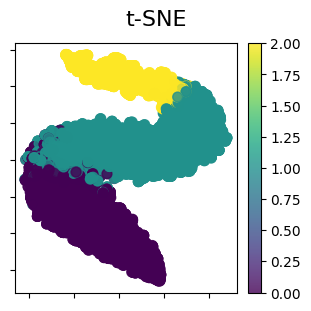

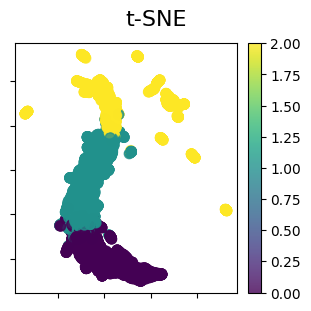

In [76]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(embs)
plot_2d(S_t_sne, kmeans.labels_, "t-SNE")
plot_2d(u, kmeans.labels_, "t-SNE")

In [73]:
def get_subjects():
    loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
    all_ds = loaded_dataset
    for ds in all_ds.datasets:
        ds.target_name = 'subject'
    assert all_ds.datasets[0].target_name == 'subject'
    window_len_s = 10
    fs = all_ds.datasets[0].raw.info['sfreq']
    window_len_samples = int(fs * window_len_s)
    window_stride_samples = int(fs * window_len_s) # non-overlapping
    windows_ds = create_fixed_length_windows(
        all_ds, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=window_len_samples,
        window_stride_samples=window_stride_samples, drop_last_window=True,
        preload=False)
    
    labels = np.stack([data[1] for data in windows_ds])
    
    return labels

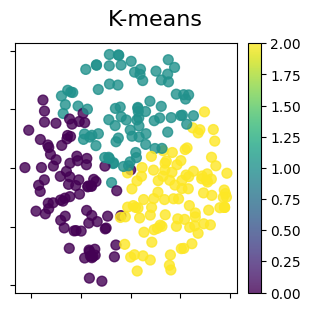

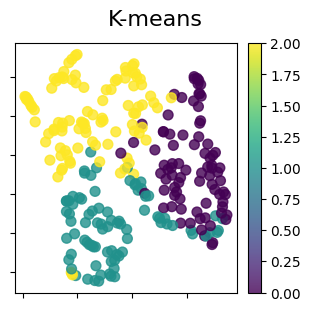

In [64]:
from sklearn.cluster import KMeans
loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
all_ds = loaded_dataset
scores = all_ds.description[['p_factor', 'attention', 'internalizing', 'externalizing']].values
mean = np.mean(scores, axis=1)
scores = scores[~np.isnan(mean)]
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=100,
    init="random",
    # max_iter=250,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(scores)
fit = umap.UMAP()
u = fit.fit_transform(scores)
scores_kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(scores)
plot_2d(S_t_sne, scores_kmeans.labels_, 'K-means')
plot_2d(u, scores_kmeans.labels_, 'K-means')

In [ ]:
scores_subjects = all_ds.description['subject'].values
scores_subjects = scores_subjects[~np.isnan(all_ds.description['attention'].values)]
subjects = get_subjects()
subjects_to_ignore = set(subjects) - set(scores_subjects)
print('subjects to ignore', len(subjects_to_ignore))

In [92]:
scores_cluster_idx = 0
embs_cluster_idx = 2
scores_cluster_subjects = set(np.unique(scores_subjects[scores_kmeans.labels_ == scores_cluster_idx]))
print('scores cluster nsubjs', len(scores_cluster_subjects))
cluster_subjects = set(np.unique(subjects[kmeans.labels_ == embs_cluster_idx]))
print('embs cluster nsubjs', len(cluster_subjects))


scores cluster nsubjs 82
embs cluster nsubjs 95


In [99]:
print('Number of overlapping subjects between window clusters', len(set(np.unique(subjects[kmeans.labels_ == 1])).intersection(set(np.unique(subjects[kmeans.labels_ == 0])))))
print("This shows that a subject's windows do not cleanly fall into a single cluster with our embeddings")


Number of overlapping subjects between window clusters 212
This shows that a subject's windows do not cleanly fall into a single cluster with our embeddings


34
[False False False ... False False False]


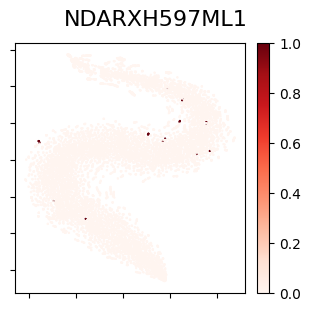

In [137]:
subject = 'NDARXH597ML1'
embs_NDARRD326KB9 = embs[subjects == subject]
print(np.sum(subjects == subject))
print(subjects == subject)
def add_2d_scatter_greys(ax, points, points_color, title=None):
    x, y = points.T
    scatter = ax.scatter(x, y, c=points_color, cmap='Reds', s=0.3, alpha=1)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    return scatter
fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
fig.suptitle(subject, size=16)
scatter = add_2d_scatter_greys(ax, S_t_sne, (subjects == subject).astype(int))
plt.colorbar(scatter, ax=ax)
plt.show()


From the subject embedding plot above we notice that the majority of points (windows) of the subject belong to the same kmean cluster. Maybe if do subject-cluster assignment using a percentage threshold we might get a clearer assignment

### age

(10679,)


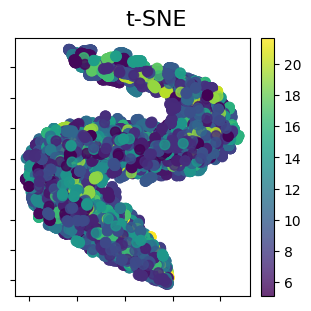

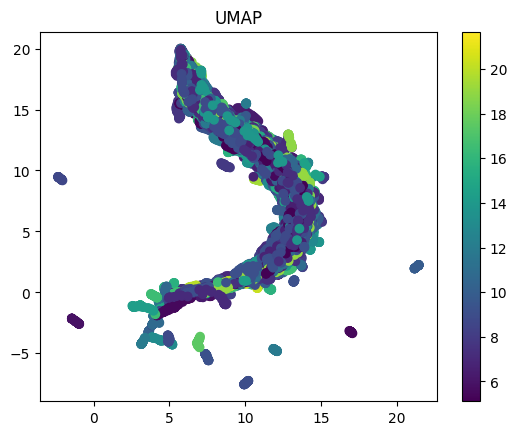

In [26]:
labels = get_labels('age')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

### p_factor

(10679,)


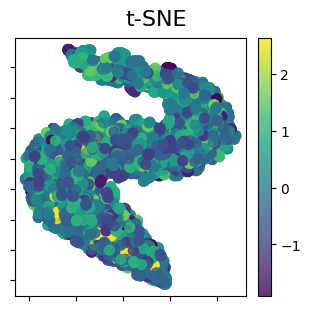

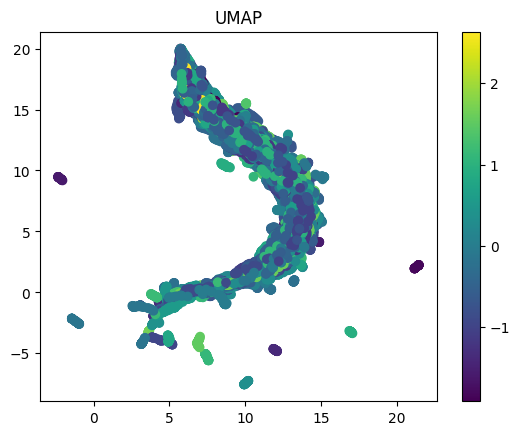

In [27]:
labels = get_labels('p_factor')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

### sex

(10679,)


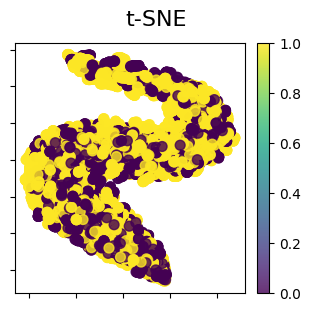

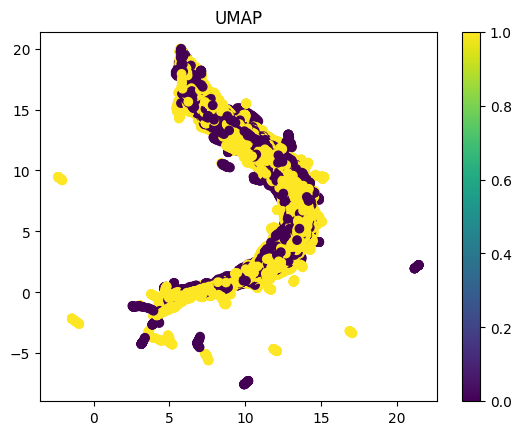

In [28]:
labels = get_labels('sex')
print(labels.shape)
labels = [0 if l == 'F' else 1 for l in labels]
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

### internalizing

(10679,)


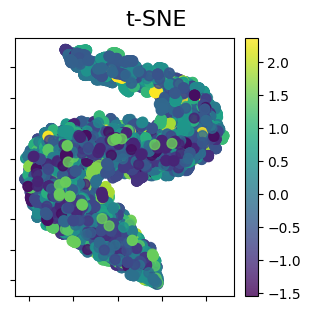

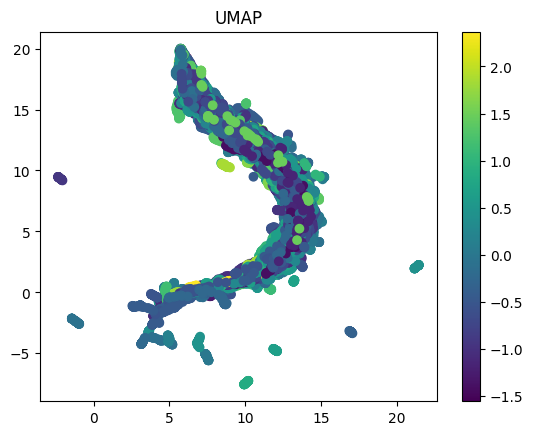

In [29]:
labels = get_labels('internalizing')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

In [18]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
isnan = np.isnan(labels)
embs = embs[~isnan]
labels = labels[~isnan]
regr.fit(embs, labels)
# regr.predict(embs)
regr.score(embs, labels)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### externalizing

(10679,)


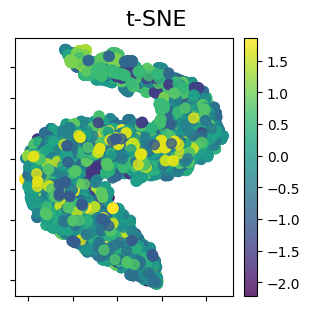

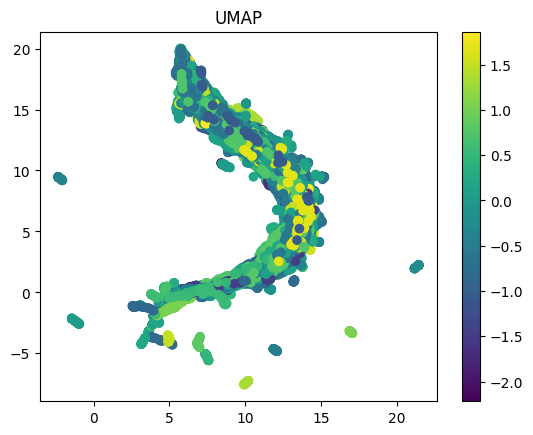

In [30]:
labels = get_labels('externalizing')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

### attention

(10679,)


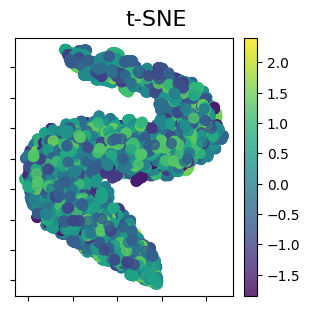

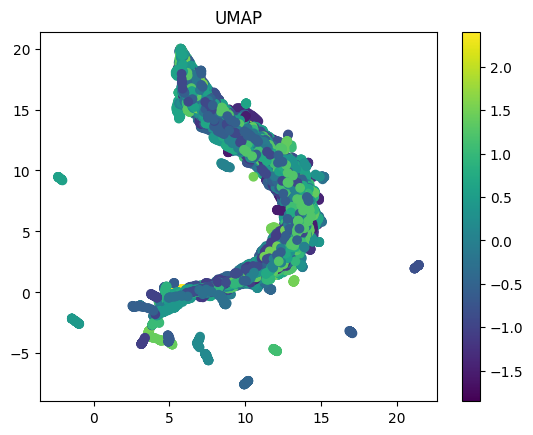

In [31]:
labels = get_labels('attention')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

In [117]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
import sys
sys.path.insert(0, '/home/dung/eeg-ssl/libs')
from libs.ssl_model import VGGSSL

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_ds[0][0].shape
print(n_channels, input_size_samples)
emb_size = 100
classes = list(range(5))
sfreq = 250

# emb = VGGSSL()
emb = ShallowFBCSPNet(
    n_chans=n_channels,
    sfreq=sfreq,
    n_outputs=emb_size,
    # n_conv_chs=16,
    n_times=input_size_samples,
    input_window_seconds=window_len_s,
    # dropout=0,
    # apply_batch_norm=True,
)


class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.pooling = nn.AdaptiveAvgPool2d(32)
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, emb_size),
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        z = self.pooling(torch.abs(z1 - z2)).flatten(start_dim=1)

        return self.clf(z).flatten()

model_random = ContrastiveNet(emb, emb_size).to(device)

129 2500


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [119]:
model_random.eval()
embs_random = get_embs(model_random, windows_ds, batch_size)
print(embs_random.shape)

torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([500, 129, 2500])
torch.Size([179, 129, 2500])
(10679, 100)


In [121]:
from sklearn import datasets, manifold
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=10,
    init="random",
    # max_iter=250,
    random_state=0,
)
%time S_t_sne = t_sne.fit_transform(embs_random)
fit = umap.UMAP()
%time u = fit.fit_transform(embs_random)

CPU times: user 2min 26s, sys: 0 ns, total: 2min 26s
Wall time: 6.15 s
CPU times: user 11.2 s, sys: 3.16 s, total: 14.4 s
Wall time: 591 ms


(10679,)


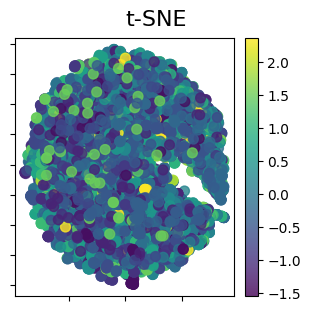

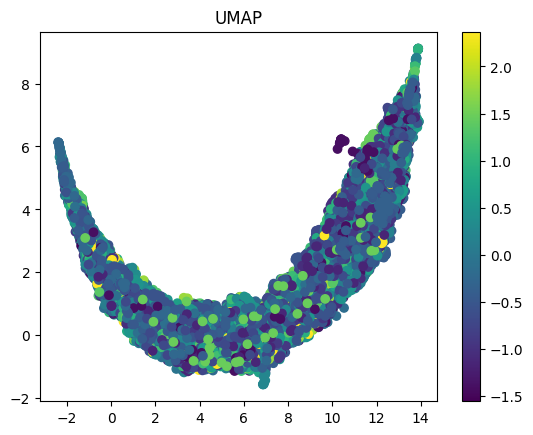

In [123]:
labels = get_labels('internalizing')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
isnan = np.isnan(labels)
embs_random = embs_random[~isnan]
labels = labels[~isnan]
regr.fit(embs_random, labels)
# regr.predict(embs)
regr.score(embs_random, labels)

0.047537771148656094

: 

(10679,)


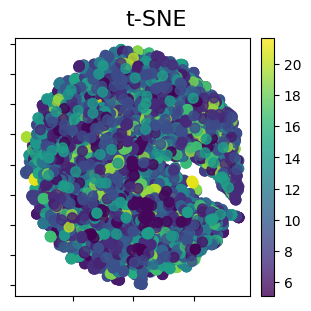

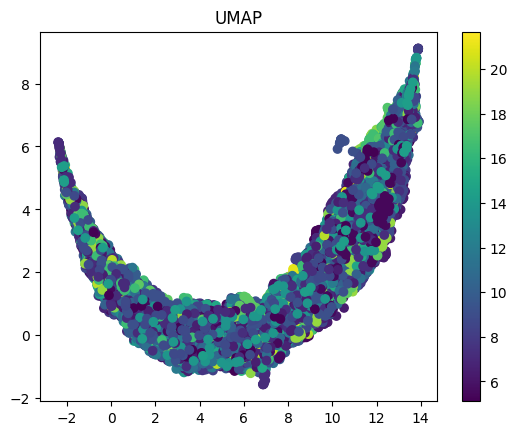

In [125]:
labels = get_labels('age')
print(labels.shape)
plot_2d(S_t_sne, labels, "t-SNE")
scatter = plt.scatter(u[:,0], u[:,1], c=labels)
plt.colorbar(scatter)
plt.title('UMAP');